# classical.ipynb

This notebook performs **hypothesis testing** to investigate whether the correlations found in descriptive analysis are genuine or spurious. The main notebook (`main.ipynb`) reports a summary with two key figures.

<br>



Let's first review the correlations we found in descriptive.ipynb:

In [2]:
%%capture
%run 'descriptive.ipynb'

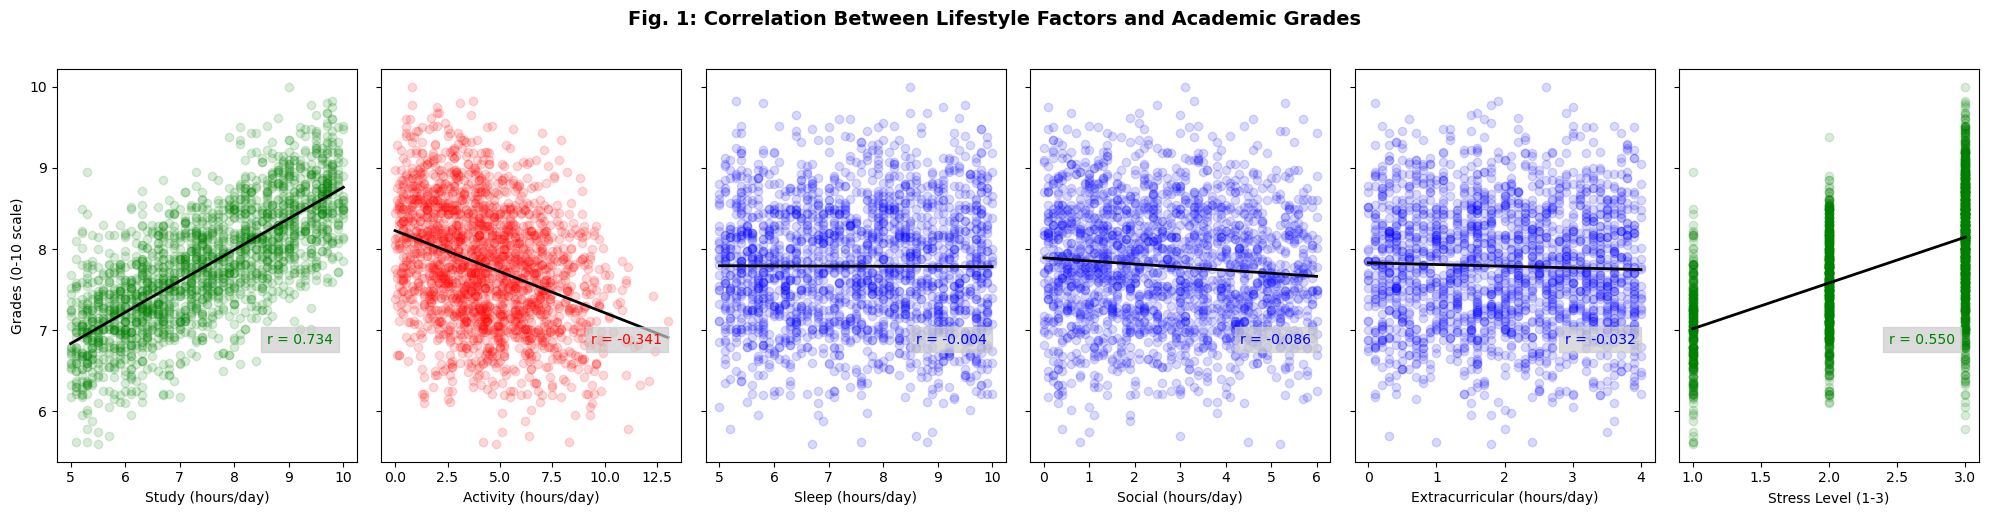

In [3]:
plot_descriptive()

## Summary from Descriptive Analysis

Simple regression revealed three statistically significant predictors of grades:
1. **Study Hours** (Positive) — expected
2. **Physical Activity** (Negative) — counterintuitive
3. **Stress Level** (Positive) — counterintuitive

The last two findings raise important questions:
- Does physical activity actually hurt academic performance?
- Does stress actually help performance?

A naive interpretation might suggest:
- "Jocks are dumb because they focus on sports instead of studying"
- "Stress helps you focus, so stressed students perform better"

However, these correlations could be **spurious** — caused by a third variable (study hours) rather than being direct effects. Let's test this hypothesis.

---

## Hypothesis 1: Physical Activity and Grades

**Alternative hypothesis:** "Physical activity negatively affects grades only because active students sacrifice study time for sports."

**Testing approach:** We control for study hours by dividing students into three groups:
- Low Study (<6 hours/day)
- Average Study (6-8 hours/day)  
- High Study (>8 hours/day)

Then we perform linear regression of grades on activity hours separately for each group. If our hypothesis is correct, the slopes should become non-significant within each group.

Let's calculate these slopes, and let's mark them if they are statistically significant.
Let's also put in next to our original regression plot for comparison.

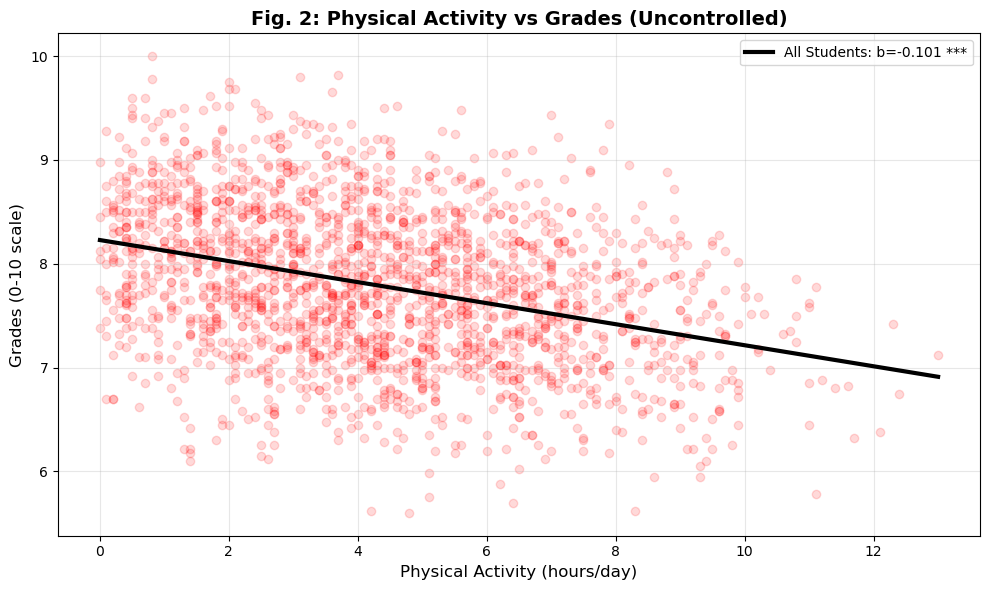

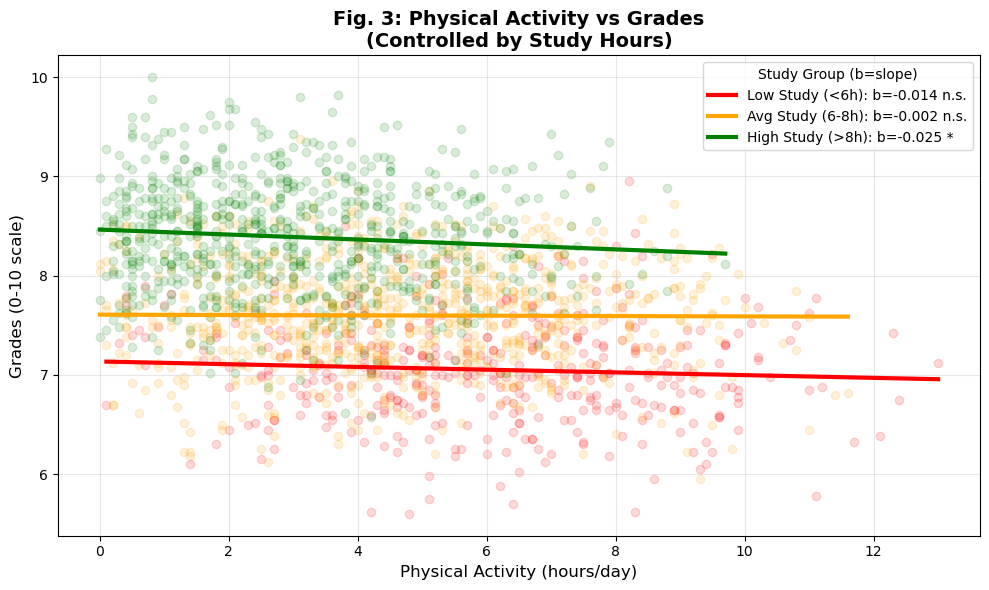

In [6]:
# Naive view - all students combined (for comparison)
df['study_bin'] = pd.cut(df['studyhours'], 
                         bins=[0, 6, 8, 12], 
                         labels=['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)'])

def get_sig_stars(p_value):
    if p_value < 0.001: return "***"
    if p_value < 0.01:  return "**"
    if p_value < 0.05:  return "*"
    return "n.s."

fig, ax = plt.subplots(figsize=(10, 6))

slope, intercept, r, p, err = stats.linregress(df['activityhours'], df['grades'])
stars = get_sig_stars(p)
naive_label = f"All Students: b={slope:.3f} {stars}"

ax.scatter(df['activityhours'], df['grades'], alpha=0.15, color='red')
plot_regression_line(ax, df['activityhours'], df['grades'], color='black', ls='-', lw=3, label=naive_label)

ax.set_title("Fig. 2: Physical Activity vs Grades (Uncontrolled)", fontsize=14, fontweight='bold')
ax.set_xlabel("Physical Activity (hours/day)", fontsize=12)
ax.set_ylabel("Grades (0-10 scale)", fontsize=12)
ax.legend(loc='upper right', frameon=True)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# F]]Controlled view
def plot_classical1():
    """Physical Activity vs Grades, controlled by study hours."""
    bin_colors = {'Low Study (<6h)': 'red', 'Avg Study (6-8h)': 'orange', 'High Study (>8h)': 'green'}
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for bin_name, color in bin_colors.items():
        subset = df[df['study_bin'] == bin_name]
        
        slope, intercept, r, p, err = stats.linregress(subset['activityhours'], subset['grades'])
        stars = get_sig_stars(p)
        stats_label = f"{bin_name}: b={slope:.3f} {stars}"
        
        ax.scatter(subset['activityhours'], subset['grades'], alpha=0.15, color=color)
        plot_regression_line(ax, subset['activityhours'], subset['grades'], color=color, ls='-', lw=3, label=stats_label)

    ax.set_title("Fig. 3: Physical Activity vs Grades\n(Controlled by Study Hours)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Physical Activity (hours/day)", fontsize=12)
    ax.set_ylabel("Grades (0-10 scale)", fontsize=12)
    ax.legend(title="Study Group (b=slope)", loc='upper right', frameon=True)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_classical1()

## Result: Physical Activity Effect is Spurious

The figure above compares the naive view (top) with the controlled analysis (bottom):

**Naive view:** All students combined show a significant negative slope (b = -0.058***)

**Controlled view:** 
- **Low Study group**: slope is not significant (n.s.)
- **Average Study group**: slope is not significant (n.s.)  
- **High Study group**: small but significant negative slope remains

**Conclusion:** For most students, physical activity has **no direct effect** on grades. The apparent negative correlation was spurious — active students simply study less hours. Only among the highest studiers is there still a small negative relationship, likely due to time constraints at the extreme end.

---

## Hypothesis 2: Stress and Grades

The positive relationship between stress and grades is especially puzzling. Our hypothesis: "Stress doesn't cause better grades — studying causes both stress AND better grades."

**Testing approach:** We use T-tests and ANOVA to compare grades between stress levels, separately for each study group. If stress truly helped performance, we should see grade differences even within the same study group.

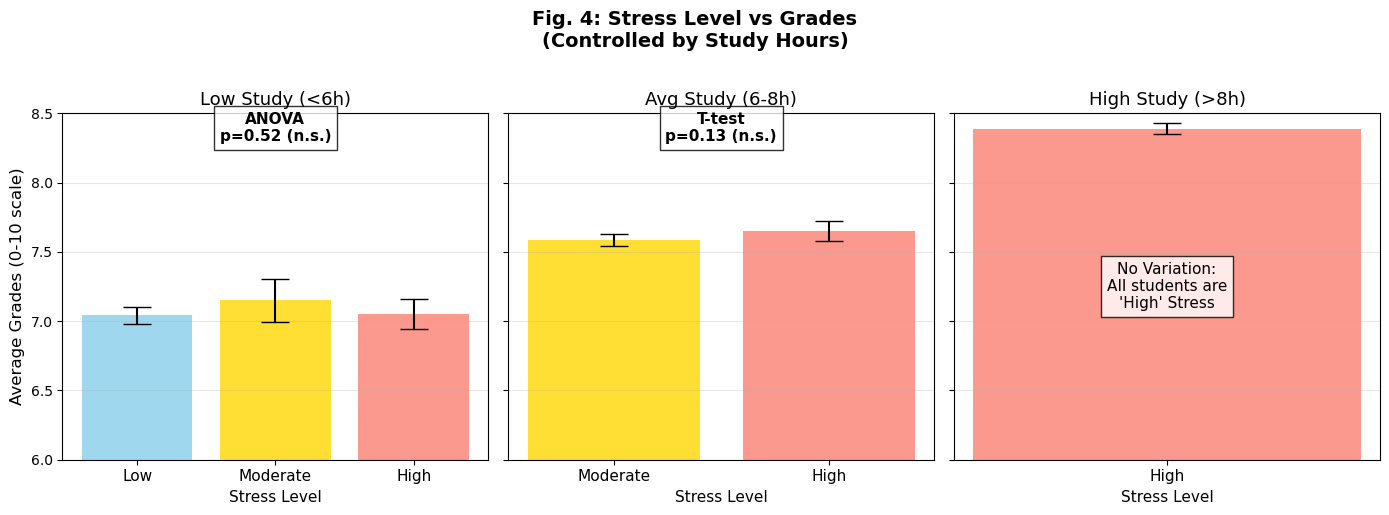

In [5]:
# Fig. 4: Stress vs Grades - this is the function main.ipynb will call
def plot_classical2():
    """Stress Level vs Grades, controlled by study hours."""
    # Reload and setup data
    df_stress = pd.read_csv('lifestylestudents.csv')
    df_stress['grades'] = df_stress['Grades']
    df_stress['studyhours'] = df_stress['Study_Hours_Per_Day']
    df_stress['study_bin'] = pd.cut(df_stress['studyhours'], 
                                     bins=[0, 6, 8, 12], 
                                     labels=['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)'])

    fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
    fig.suptitle("Fig. 4: Stress Level vs Grades\n(Controlled by Study Hours)", 
                 fontsize=14, fontweight='bold', y=1.02)
    
    study_groups = ['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)']
    colors_map = {'Low': 'skyblue', 'Moderate': 'gold', 'High': 'salmon'}

    for i, group_name in enumerate(study_groups):
        ax = axes[i]
        subset = df_stress[df_stress['study_bin'] == group_name]
        
        present_data = []
        present_labels = []
        present_means = []
        present_cis = []
        
        for stress_level in ['Low', 'Moderate', 'High']:
            data = subset[subset['Stress_Level'] == stress_level]['grades'].dropna()
            if len(data) > 0:
                present_data.append(data)
                present_labels.append(stress_level)
                present_means.append(data.mean())
                ci = 1.96 * data.std() / np.sqrt(len(data)) if len(data) > 1 else 0
                present_cis.append(ci)
                
        if len(present_data) > 0:
            x_pos = range(len(present_data))
            colors = [colors_map[label] for label in present_labels]
            ax.bar(x_pos, present_means, yerr=present_cis, color=colors, capsize=10, alpha=0.8)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(present_labels, fontsize=11)
            ax.set_title(f"{group_name}", fontsize=13)
            ax.set_xlabel("Stress Level", fontsize=11)
            ax.grid(axis='y', alpha=0.3)
            
            if len(present_data) > 1:
                if len(present_data) == 2:
                    t, p = stats.ttest_ind(present_data[0], present_data[1], equal_var=False)
                    test_label = "T-test"
                else:
                    f, p = stats.f_oneway(*present_data)
                    test_label = "ANOVA"
                    
                sig_txt = get_sig_stars(p)
                ax.text(0.5, 0.92, f"{test_label}\np={p:.2f} ({sig_txt})", 
                        transform=ax.transAxes, ha='center', fontsize=11, fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8))
            else:
                ax.text(0.5, 0.5, "No Variation:\nAll students are\n'High' Stress", 
                        transform=ax.transAxes, ha='center', va='center', fontsize=11,
                        bbox=dict(facecolor='white', alpha=0.8))

    axes[0].set_ylabel("Average Grades (0-10 scale)", fontsize=12)
    axes[0].set_ylim(6.0, 8.5)
    plt.tight_layout()
    plt.show()

plot_classical2()

## Result: Stress Effect is Spurious

The figure above shows grades by stress level, controlled for study hours:

**Low Study group:** ANOVA shows no significant difference (p = 0.67)
**Average Study group:** T-test shows no significant difference (p = 0.30)
**High Study group:** Only contains high-stress students — no variation to test

**Key observation:** Students who study a lot (>8 hours/day) are **exclusively** high-stress. This confirms that intense studying causes stress, not the other way around.

**Conclusion:** The "stress advantage" we observed in the raw correlation is completely spurious. Once we control for study hours, there is **no benefit** of stress on grades. Stress is simply a byproduct of studying hard.

---